In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
datadir = os.path.join('..', 'data', 'modeling', 'interpret')
adata = sc.read_h5ad(os.path.join(datadir, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1575028 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

In [ ]:
def get_pearsonr(X: csr_matrix, y: np.ndarray) -> np.ndarray:
    n = y.size
    s_y, mu_y = y.std(ddof = 1), y.mean()
    sum_x  = np.asarray(X.sum(0)).ravel()
    sum_x2 = np.asarray(X.multiply(X).sum(0)).ravel()
    dot = y @ X
    mu_x = sum_x / n
    s_x = np.sqrt((sum_x2 - n * mu_x ** 2) / (n - 1))
    cov = (dot - n * mu_x * mu_y) / (n - 1)
    corr = cov / (s_x * s_y)
    corr[s_x == 0] = np.nan
    return corr

ig = adata.layers['integrated_gradients']
z = adata.obs.latent_z.values
corr = get_pearsonr(ig, z)
ix, name = adata.var_names, 'pearsonr'
corr = (pd.Series(corr, index = ix, name = name)
        .sort_values(key = abs, ascending = False))
corr

Marcks     0.820915
Eef1g      0.806805
Rps20      0.805982
Gabarap    0.799973
Ncl        0.785884
             ...   
Dlx5       0.001846
Sntb1     -0.001808
Hbb-y      0.000821
Hmga1     -0.000548
Gadd45a    0.000379
Name: pearsonr, Length: 856, dtype: float64

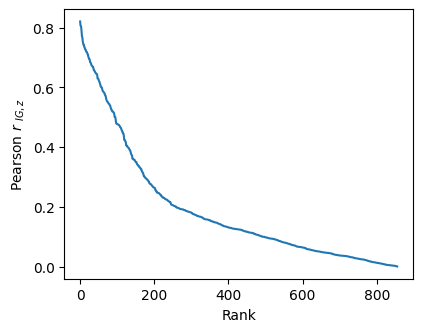

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (4.5, 3.5))
ax.plot(corr.abs().values)
ax.set_xlabel('Rank')
ax.set_ylabel(r'Pearson $r$ $_{IG,z}$')
plt.show()